# Getting Started with DRYTorch

This notebook demonstrates a simple application of the DRYTorch library for organizing machine learning experiments.

## Deep Prior Upsampling

We will perform image super-resolution (super-resolution) using a technique called Deep Image Priors (DIP).

The approach is as follows: We train the network to minimize the difference between its downsampled output and the low-resolution target image. The network should be able to generalize this training objective and reconstruct the high-resolution detail. We then evaluate its output against the original image, using simple bilinear interpolation of the low-resolution version as a non-learning baseline for comparison.


### Requirements
For this tutorial, there are no required optional dependencies.

### Preprocess the image
The target image has a resolution of 128 x 128. We downsample it to 64 x 64 using bilinear interpolation, and use it again to upsample back to the original resolution to create a baseline.


In [1]:
import numpy as np
import torch

from PIL import Image as Image


TARGET_SIZE = 128
DOWNSAMPLED_SIZE = 64


def interpolate(image_torch: torch.Tensor, target_size: int) -> torch.Tensor:
    """Performs an interpolation on an image array.

    Args:
        image_torch: a NumPy array of an image.
        target_size: resulting height and width

    Returns:
        A torch tensor of shape (batch, target_size, target_size).
    """
    return torch.nn.functional.interpolate(
        image_torch,
        size=(target_size, target_size),
        mode='bilinear',
    )


flower_np = np.load(file='flower.npy')
flower_torch = torch.from_numpy(flower_np).permute(2, 0, 1).float()
flower_torch /= 255
flower_torch = interpolate(flower_torch.unsqueeze(0), TARGET_SIZE).squeeze()
flower_torch_downsampled = interpolate(
    flower_torch.unsqueeze(0), DOWNSAMPLED_SIZE
).squeeze()
baseline_reconstruction = interpolate(
    flower_torch_downsampled.unsqueeze(0), TARGET_SIZE
).squeeze()

Let's visualized the image we want to reproduce and the baseline reconstruction.

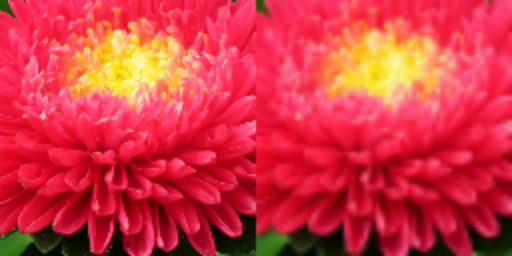

In [2]:
from IPython.display import HTML
from IPython.display import display as ip_display


def display_tensor_images(named_images: dict[str, torch.Tensor]) -> None:
    """Display a PyTorch image tensor.

    Args:
        named_images: list of tensors of dimensions (channels, height, width).
    """
    title_html = ''

    for image_name in named_images:
        title_html += f"""
        <div style="text-align: center; width: 256px; font-size: 2em;">
        {image_name}
        </div>"""

    ip_display(HTML(f"""<div style=" display: flex;">{title_html}</div>"""))
    image = torch.cat(list(named_images.values()), dim=2)
    image = torch.nn.functional.interpolate(
        image.unsqueeze(0),
        size=(256, 256 * len(named_images)),
        mode='bilinear',
    ).squeeze()

    np_array = image.detach().cpu().permute(1, 2, 0).numpy().copy()
    np_array_int = (np_array * 255).astype(np.uint8)
    ip_display(Image.fromarray(np_array_int))
    return


display_tensor_images(
    {'Original': flower_torch, 'Baseline': baseline_reconstruction}
)

## Set up the experiment
In DRYTorch, an experiment is a reproducible execution entirely defined by its configuration file. A run is a session that you can later resume. Multiple runs of the same experiment are for reproducibility and debugging. 


### Define the Specification
DRYTorch supports scope-dependent configuration, meaning the experiment configuration is globally available during the experimental run. This design avoids the need to explicitly pass the configuration as a parameter and ensures it is reliably aligned with the current experiment. 

For improved type checking and auto-completion, it is recommended to subclass the base experiment class, explicitly integrating your specific configuration structure.


*Tip: use Pydantic dataclasses to validate your settings.*


In [ ]:
import dataclasses as dataclasses

from drytorch import Experiment


@dataclasses.dataclass(frozen=True)
class ArchitercturalSettings:
    """Architectural settings for a Resnet with three stages.

    Attributes:
        layer_normalization: whether to use layer normalization.
        n_blocks_per_stage: number of convolutional blocks in the three stages.
        max_width: number of channels of the middle stage (half in the others).
    """

    norm_flag: bool = False
    n_blocks_per_stage: tuple[int, int, int] = (2, 2, 2)
    max_width: int = 32


@dataclasses.dataclass(frozen=True)
class TrainingSettings:
    """Training settings for the current experiment.

    Attributes:
        lr: learning rate.
        n_epochs: number of training epochs.
    """

    lr: float = 0.001
    n_epochs: int = 30


@dataclasses.dataclass
class AllSettings:
    """General settings for the current experiment.

    Attributes:
        n_epochs: number of training epochs.
        batch_size: how many samples in each mini-batch
    """

    architecture = ArchitercturalSettings()
    train = TrainingSettings()


class UpsamplingExperiment(Experiment[AllSettings]):
    """Class for upsampling experiments."""

    pass

### Create an experiment

Together with the configuration, you can assign a name and a directory to the experiment which will determine where the checkpoints, the metadata and the logs will be located.

In [4]:
import pathlib


settings = AllSettings()
experiment = UpsamplingExperiment(
    settings, name='Getting Started', par_dir=pathlib.Path('experiments')
)

### Select the trackers
Trackers are responsible for logging and plotting but have no impact on the experiment's computation. By default, DRYTorch provides trackers for logging, displaying a progress bar, and storing metadata.
Here, we want to save the training and test results in `.csv` files, so we add the `CSVDumper` to the default ones.

In [5]:
from drytorch.trackers.csv import CSVDumper


experiment.trackers.register(CSVDumper())

### Create the run and start the experiment
It is recommended to create a new run or resume a previous one using the `create_run` method. 

The Run instance works best as a context manager:

```python
with experiment.create_run():
    execute_ml_op()

```

However, in notebooks starting the run procedurally is more practical.

In [6]:
run = experiment.create_run()
run.start()

[2025-11-17 10:54:26] - Running experiment: Getting Started.


## Custom classes
The DRYTorch philosophy prioritizes maximum flexibility, allowing you to write custom classes and structured data for your task while taking full advantage of type annotations. The classes should have as few arguments as possible and rely on the global configuration for their instantiation.


### Define Data Structures

Following its phylosophy, DRYTorch supports structured inputs and outputs for your model, as well as targets for your loss. This is particularly helpful for unstructured data of different inputs (e.g. modalities) or targets.

The structure for inputs and targets must be compatible with the default PyTorch `collate_fn`. This means it can be a `torch.Tensor`, a list of tensors, or a namedtuple of tensors. Outputs can have an arbitrary type.


In [7]:
from typing import NamedTuple

import torch


class Inputs(NamedTuple):
    """Structured input.

    Deep priors do not use any input, so this class is empty
    """


class TrainingTargets(NamedTuple):
    """Structured target for training.

    Attributes:
        flower_downsampled: flower downsampled 2 to 1.
    """

    flower_downsampled: torch.Tensor


class TestTargets(NamedTuple):
    """Structured target for testing.

    Attributes:
        flower_original: the original flower array.
    """

    flower_original: torch.Tensor


@dataclasses.dataclass
class Outputs:
    """Structured target.

    Attributes:
        flower_reconstructed: reconstructed array of the flower image.
    """

    flower_reconstructed: torch.Tensor

### Create the Datasets
The test and training dataset consist of a single image. In the test dataset, the image is the one we want to reconstruct, while in the training dataset the image is the downsampled version.

DRYTorch expects an (annotated) instance of `torch.utils.data.Dataset`. 

In [8]:
import torch

from torch.utils import data


class TestDataset(data.Dataset[tuple[Inputs, TestTargets]]):
    """This dataset evaluates the reconstruction of the image.

    Attributes:
        target_image: the image to reconstruct
    """

    def __init__(self, target_image: torch.Tensor) -> None:
        """Constructor.

        Args:
            target_image: the image to reconstruct
        """
        super().__init__()
        self.target_image = target_image

    def __len__(self) -> int:
        """Number of samples to test."""
        return 1

    def __getitem__(self, _) -> tuple[Inputs, TestTargets]:
        """Method to overwrite to define the batch.

        Returns:
            Tuple with Inputs and Targets instances.
        """
        inputs = Inputs()
        targets = TestTargets(flower_original=self.target_image)
        return inputs, targets


class TrainingDataset(data.Dataset[tuple[Inputs, TrainingTargets]]):
    """This dataset trains the network to reconstruct the image.

    Attributes:
        image_downsampled: the image to upsample.
    """

    def __init__(self, downsampled_image: torch.Tensor) -> None:
        """Constructor.

        Args:
            downsampled_image: the image to upsample.
        """
        super().__init__()
        self.downsampled_image = downsampled_image

    def __len__(self) -> int:
        """Number of iteration per epoch."""
        return 32

    def __getitem__(self, _) -> tuple[Inputs, TrainingTargets]:
        """Method to overwrite to define the batch.

        Returns:
            tuple with Inputs and Targets instances.
        """
        inputs = Inputs()
        targets: TrainingTargets = TrainingTargets(
            flower_downsampled=self.downsampled_image
        )
        return inputs, targets


training_dataset = TrainingDataset(flower_torch_downsampled)
test_dataset = TestDataset(flower_torch)

## Create the Network

This implementation of a Deep Prior network uses an internal fixed parameter as the input to a residual convolutional network.

You define the PyTorch Module for your model as usual, defining (and annotating) the forward method.


In [9]:
from torch import nn


class ResNetBlock(nn.Module):
    """The fundamental residual block for ResNet."""

    def __init__(self, in_channels: int, out_channels: int) -> None:
        """Initiates two convolution and the skip connection."""
        super().__init__()
        cfg_arc = UpsamplingExperiment.get_config().architecture
        norm_flag = cfg_arc.norm_flag
        self.net = nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, kernel_size=3, padding=1, bias=False
            ),
            # FIX: LayerNorm needs the feature map shape if used on 2D data
            # Here, we keep it as Identity if norm_flag is false
            nn.LayerNorm(out_channels) if norm_flag else nn.Identity(),
            nn.ReLU(inplace=True),
            nn.Conv2d(
                out_channels,
                out_channels,
                kernel_size=3,
                padding=1,
                bias=False,
            ),
            nn.LayerNorm(out_channels) if norm_flag else nn.Identity(),
        )

        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_channels,
                    out_channels,
                    kernel_size=1,
                    bias=False,
                ),
                nn.LayerNorm(out_channels) if norm_flag else nn.Identity(),
            )
        self.final_activation = nn.ReLU(inplace=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Passes the input through the net, adding the residual connection."""
        out = self.net(x) + self.shortcut(x)
        out = self.final_activation(out)
        return out


class ResNetStage(nn.Sequential):
    """A single stage of the ResNet architecture."""

    def __init__(
        self, in_channels: int, out_channels: int, num_blocks: int
    ) -> None:
        """Initializes a stage with the required number of blocks."""
        layers: list[nn.Module] = []
        current_channels = in_channels
        for _ in range(num_blocks):
            layers.append(ResNetBlock(current_channels, out_channels))
            current_channels = out_channels
        super().__init__(*layers)


class ResNet(nn.Sequential):
    """A ResNet model for image reconstruction."""

    def __init__(self) -> None:
        """Initializes the entire ResNet structure."""
        cfg_arc = UpsamplingExperiment.get_config().architecture
        norm_flag = cfg_arc.norm_flag
        max_width = cfg_arc.max_width
        num_blocks = cfg_arc.n_blocks_per_stage

        layers: list[nn.Module] = [
            nn.Conv2d(16, max_width // 2, kernel_size=3, padding=1, bias=False),
            nn.LayerNorm(max_width // 2) if norm_flag else nn.Identity(),
            nn.ReLU(inplace=True),
            ResNetStage(max_width // 2, max_width, num_blocks[0]),
            ResNetStage(max_width, max_width, num_blocks[1]),
            ResNetStage(max_width, max_width // 2, num_blocks[2]),
            nn.Conv2d(max_width // 2, 3, kernel_size=3, padding=1),
            nn.Sigmoid(),
        ]
        super().__init__(*layers)


class DeepPriorNet(nn.Module):
    """A net with a fixed input parameter."""

    def __init__(self) -> None:
        """Instantiate the net and the fixed input."""
        super().__init__()
        self.fixed_input = torch.nn.Parameter(
            torch.randn(1, 16, TARGET_SIZE, TARGET_SIZE)
        )
        self.net = ResNet()

    def forward(self, _: Inputs) -> Outputs:
        """Call the net on the fixed input."""
        return Outputs(self.net(self.fixed_input))


network = DeepPriorNet()


### Define the loss and metric functions

In this experiment we are only going to use the Mean Square Error (MSE) for training and the Peak Signal-to-Noise Ratio (PSNR) for evaluating the super-resolution image. The bilinear interpolation baseline has a PSNR of 25.90. 

DRYTorch expects loss and metric functions that take outputs and targets as arguments.


In [10]:
def psnr(recon: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    """Compute Peak Signal-to-Noise Ratio between two images in [0, 1] range."""
    mse = nn.functional.mse_loss(recon, target)

    if mse == 0:
        return torch.tensor(torch.inf)

    return -10 * torch.log10(mse)


def target_psnr(outputs: Outputs, targets: TestTargets) -> torch.Tensor:
    """Mean Square Error in the target space."""
    return psnr(outputs.flower_reconstructed, targets.flower_original)


def downsampled_mse(outputs: Outputs, targets: TrainingTargets) -> torch.Tensor:
    """Mean Square Error in the downsampled space."""
    reconstruction_downsampled = interpolate(
        outputs.flower_reconstructed, DOWNSAMPLED_SIZE
    )
    return nn.functional.mse_loss(
        reconstruction_downsampled, targets.flower_downsampled
    )


psnr(baseline_reconstruction, flower_torch).item()

25.90180206298828

## Library implementations


DRYTorch provides default implementations for the core components of a
typical ML workflow. Below we briefly summarize the main functionalities:

- **DataLoader:**
  A data loader with “smart loading” behavior that adapts automatically when
  PyTorch switches to evaluation mode.

- **Model:**
  A wrapper around `torch.nn.Module` that stores additional metadata and allows
  saving and loading model state from disk.

- **LearningSchema:**
  A dataclass that encapsulates advanced optimizer settings, schedulers, and
  gradient operations. It includes convenient methods for standard
  configurations.

- **Loss** and **Metric:**
  Classes that wrap loss and metric functions. They support operator
  overloading for combining multiple losses/metrics and provide automatic
  self-documentation.

- **Test:**
  A class for evaluating model performance on a test dataset. It reports
  metric values to registered trackers and can optionally store outputs for
  qualitative analysis.

- **Trainer:**
  Trains a model according to a given learning schema and optionally validates
  it on a validation dataset. It supports callbacks executed before and after
  each epoch and can save/load checkpoints (including module and optimizer
  states).

**Note:** If the type annotations of the DataLoader, Model, and Loss/Metric are
incompatible, the type checker will raise an error when instantiating the
`Trainer` or `Test` classes.

### Train the model
We perform a basic training cycle using the library implementations.

In [11]:
from drytorch import DataLoader, LearningSchema, Loss, Model, Trainer


cfg_train = UpsamplingExperiment.get_config().train
train_loader = DataLoader(training_dataset, batch_size=1)
model = Model(network, name='DeepPriorNet')
learning_schema = LearningSchema.adam(cfg_train.lr)
loss = Loss(downsampled_mse, 'MSE downsampled')
trainer = Trainer(
    model, loader=train_loader, loss=loss, learning_schema=learning_schema
)
trainer.train(cfg_train.n_epochs)

[2025-11-17 10:54:28] - Training DeepPriorNet started.
====> Epoch  1/30:
        Trainer: 100%|██████████| 32/32, 00:03<00:00, Samples=32, MSE downsampled=5.679e-02
====> Epoch  2/30:
        Trainer: 100%|██████████| 32/32, 00:03<00:00, Samples=32, MSE downsampled=4.044e-02
====> Epoch  3/30:
        Trainer: 100%|██████████| 32/32, 00:01<00:00, Samples=32, MSE downsampled=3.570e-02
====> Epoch  4/30:
        Trainer: 100%|██████████| 32/32, 00:01<00:00, Samples=32, MSE downsampled=1.822e-02
====> Epoch  5/30:
        Trainer: 100%|██████████| 32/32, 00:01<00:00, Samples=32, MSE downsampled=8.258e-03
====> Epoch  6/30:
        Trainer: 100%|██████████| 32/32, 00:02<00:00, Samples=32, MSE downsampled=5.338e-03
====> Epoch  7/30:
        Trainer: 100%|██████████| 32/32, 00:01<00:00, Samples=32, MSE downsampled=4.962e-03
====> Epoch  8/30:
        Trainer: 100%|██████████| 32/32, 00:01<00:00, Samples=32, MSE downsampled=3.902e-03
====> Epoch  9/30:
        Trainer: 100%|██████████| 32/3

### Test the model
We evaluate the model using the PSNR metric. The score should be slightly higher than the baseline (greater than 26.00).



In [12]:
from drytorch import Metric, Test


test_loader = DataLoader(test_dataset, batch_size=1)
metric = Metric(target_psnr, 'PSNR Target', False)
test = Test(model, loader=test_loader, metric=metric)
test(store_outputs=True)


[2025-11-17 10:55:31] - Testing DeepPriorNet started.
           Test: 100%|██████████| 1/1, 00:00<00:00, Samples=1, PSNR Target=2.606e+01


### Qualitative results.
We get the stored output from the test class and 

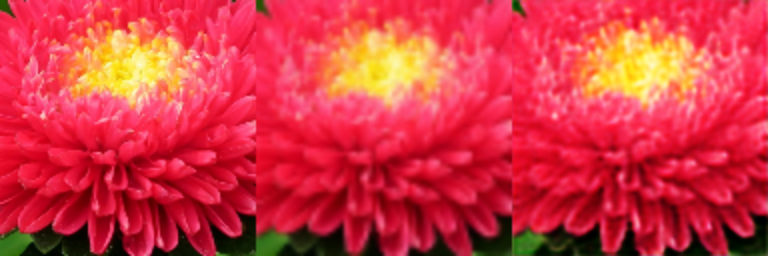

In [13]:
reconstructed = test.outputs_list[0].flower_reconstructed.squeeze()
display_tensor_images(
    {
        'Original': flower_torch,
        'Baseline': baseline_reconstruction,
        'Deep Prior': reconstructed,
    }
)

## Documentation
Documentation is stored both on disk and through the selected trackers.

- Basic run information is saved in the `.drytorch` folder.
- The `metadata` folder contains a readable representation extracted from the
  Model, Trainer, and Test classes, documenting their attributes recursively.
- The `csv` folder stores a dump of all metrics produced by the Trainer and
  Test classes.